In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import scipy.io as sio
from pandas import Series

<ipython-input-1-517a923f76b6>:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  from pandas import Series


In [2]:
%matplotlib widget


---
# VIDEO: Total and windowed variance and RMS
---


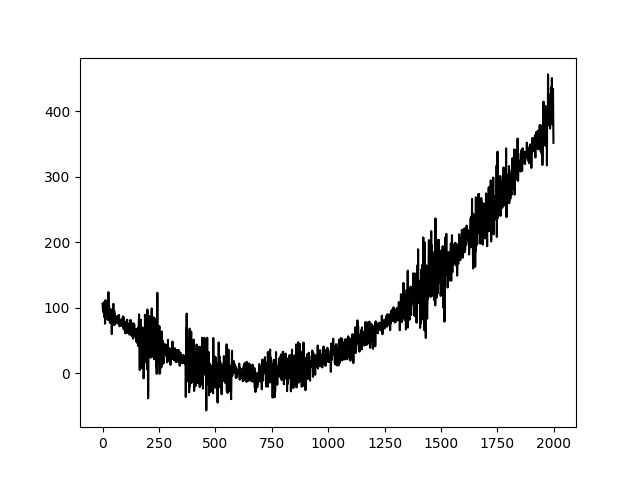

In [3]:
# generate signal with varying variability
n = 2000
p = 20 # poles for random interpolation

# amplitude modulator
ampmod = griddata(np.arange(0,p), np.random.rand(p)*30, np.linspace(0,p-1,n), method='nearest')
ampmod = ampmod + np.mean(ampmod)/3*np.sin(np.linspace(0,6*np.pi,n))

# signal and modulated noise plus quadratic
signal1 = ampmod * np.random.randn(n)
signal1 = signal1 + np.linspace(-10,20,n)**2

# plot the signal
fig1 = plt.figure()
plt.plot(signal1,'k')
plt.show()

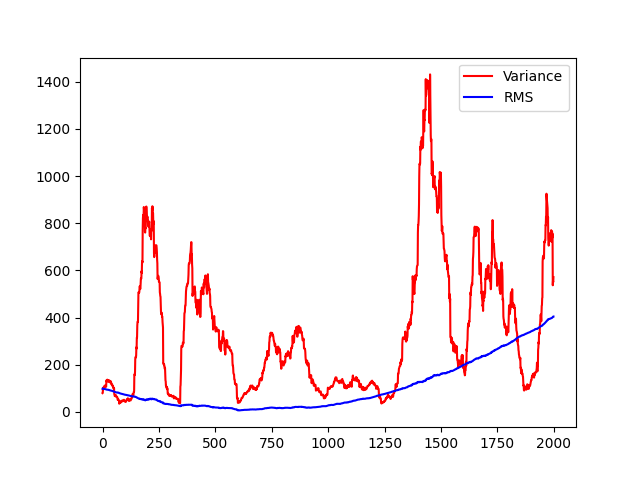

In [4]:
## compute windowed variance and RMS

# window size (NOTE: actual window is halfwin*2+1)
halfwin = 25 # in points

var_ts = np.zeros(n)
rms_ts = np.zeros(n)

for ti in range(0,n):
    
    # boundary points
    low_bnd = np.max((0,ti-halfwin))
    upp_bnd = np.min((n,ti+halfwin))
    
    # signal segment
    tmpsig = signal1[range(low_bnd,upp_bnd)]
    
    # compute variance and RMS in this window
    var_ts[ti] = np.var(tmpsig)
    rms_ts[ti] = np.sqrt(np.mean( tmpsig**2 ))

# and plot
fig2 = plt.figure()
plt.plot(var_ts,'r',label='Variance')
plt.plot(rms_ts,'b',label='RMS')
plt.legend()
plt.show()


---
# VIDEO: Signal-to-noise ratio (SNR)
---


In [ ]:

# simulation params
pnts = 1000
time = np.linspace(0,5*np.pi,pnts)

# one signal
signal1 = 3+np.sin(time)
signal1 = signal1 + np.random.randn(pnts)

# another signal
signal2 = 5 + np.random.randn(pnts) * (2+np.sin(time))



# compute SNR in sliding windows
k = int(pnts*.05)  # one-sided window is 5% of signal length

# initialize
snr_ts1 = np.zeros(pnts)
snr_ts2 = np.zeros(pnts)


# loop over time points
for i in range(0,pnts):
    
    # time boundaries
    bndL = max((0,i-k))
    bndU = min((pnts,i+k))
    
    # extract parts of signals
    sigpart1 = signal1[range(bndL,bndU)]
    sigpart2 = signal2[range(bndL,bndU)]
    
    # compute windowed SNR
    snr_ts1[i] = np.mean(sigpart1) / np.std(sigpart1)
    snr_ts2[i] = np.mean(sigpart2) / np.std(sigpart2)
    


# plot the signals
plt.subplot(211)
plt.plot(time,signal1+10,label='Signal 1')
plt.plot(time,signal2,label='Signal 2')
plt.yticks([],[])
plt.xlabel('Time (rad.)')
plt.legend()

# plot SNRs
plt.subplot(212)
plt.plot(time,snr_ts1,label='SNR 1')
plt.plot(time,snr_ts2,label='SNR 2')
plt.legend()
plt.xlabel('Time (rad.)')
plt.show()


# plot SNRs
plt.subplot(211)
plt.plot(time,snr_ts1,label='SNR 1')
plt.plot(time,snr_ts2,label='SNR 2')
plt.legend()
plt.ylabel('"Raw" SNR units')
plt.xlabel('Time (rad.)')


plt.subplot(212)
plt.plot(time,10*np.log10(snr_ts1),label='SNR 1')
plt.plot(time,10*np.log10(snr_ts2),label='SNR 2')
plt.legend()
plt.ylabel('dB SNR units')
plt.xlabel('Time (rad.)')
plt.show()

In [ ]:
##  try in a voltage time series

# import data
matdat = sio.loadmat('SNRdata.mat')
timevec = np.squeeze( matdat['timevec'] )
eegdata = matdat['eegdata']


# plot mean and std data time series
plt.subplot(211)
plt.plot(timevec,np.mean(eegdata,2).T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage ($\mu$V)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Average time series')


plt.subplot(212)
plt.plot(timevec,np.std(eegdata,2).T)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (std.)')
plt.legend(['Chan 1','Chan 2'])
plt.title('Standard deviation time series')

plt.show()




## compute SNR
snr = np.mean(eegdata,2) / np.std(eegdata,2)

# plot
plt.plot(timevec,10*np.log10(snr).T)
plt.xlabel('Time (ms)')
plt.ylabel('SNR 10log_{10}(mean/var)')
plt.legend(['Chan 1','Chan 2'])
plt.title('SNR time series')
plt.show()

In [ ]:
## alternative: SNR at a point

# pick time point
timepoint = 375
basetime  = [-500, 0]

# convert baseline time window to indices


# average over repetitions
erp = np.mean(eegdata,2)
bidx1 = np.argmin((timevec-basetime[0])**2)
bidx2 = np.argmin((timevec-basetime[1])**2)


# SNR components
snr_num = erp[:,np.argmin((timevec-timepoint)**2)]
snr_den = np.std( erp[:,range(bidx1,bidx2)] ,1)



# display SNR in the command window
print('SNR at %d ms in channel 1 = %g' %(timepoint,snr_num[0]/snr_den[0]) )
print('SNR at %d ms in channel 2 = %g' %(timepoint,snr_num[1]/snr_den[1]) )



---
# VIDEO: Coefficient of variation
---


In [ ]:
# number of data points
nmeans = 100
nstds  = 110

# ranges of means (den.) and standard deviations (num.)
means = np.linspace(.1,5,nmeans)
stds  = np.linspace(.1,10,nstds)


# initialize matrix
cv = np.zeros((nmeans,nstds))

# loop over all values and populate matrix
for mi in range(0,nmeans):
    for si in range(0,nstds):
        
        # coefficient of variation
        cv[mi,si] = stds[si] / means[mi]
        


# show in an image
plt.pcolormesh(stds,means,cv,vmin=0,vmax=30)
plt.ylabel('Mean')
plt.xlabel('Standard deviation')
plt.colorbar()
plt.show()


---
# VIDEO: Entropy
---


In [ ]:
## "discrete" entropy

# generate data
N = 1000
numbers = np.ceil( 8*np.random.rand(N)**2 )


# get counts and probabilities
u = np.unique(numbers)
probs = np.zeros(len(u))

for ui in range(0,len(u)):
    probs[ui] = np.sum(numbers==u[ui]) / N


# compute entropy
entropee = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )


# plot
plt.bar(u,probs)
plt.title('Entropy = %g' %entropee)
plt.ylabel('Probability')
plt.show()

In [ ]:
## same procedure for spike times

# generate spike times series
spikets1 = np.zeros(N)
spikets2 = np.zeros(N)

# nonrandom
spikets1[ np.random.rand(N)>.9 ] = 1

# equal probability
spikets2[ np.random.rand(N)>.5 ] = 1

# probabilities
# (note: this was incorrect in the video; the entropy of the entire time
# series requires the probability of each event type. And the theoretical
# entropy of a random binary sequence is 1.)
probs1 = ( np.sum(spikets1==0)/N, np.sum(spikets1==1)/N )
probs2 = ( np.sum(spikets2==0)/N, np.sum(spikets2==1)/N )

# compute entropy
entropee1 = -np.sum( probs1*np.log2(probs1+np.finfo(float).eps) )
entropee2 = -np.sum( probs2*np.log2(probs2+np.finfo(float).eps) )



# convert data to pandas for smoothing
spikets1 = Series(spikets1).rolling(window=10)
spikets2 = Series(spikets2).rolling(window=10)


plt.plot(np.arange(0,N),spikets1.mean(),label='Spikes 1')
plt.plot(np.arange(0,N),spikets2.mean(),label='Spikes 2')
plt.legend()
plt.show()


plt.bar([1,2],[ entropee1, entropee2 ])
plt.xlim([0, 3])
plt.xticks([1,2],('TS1','TS2'))
plt.ylabel('Entropy')
plt.show()


In [ ]:
## extra step for analog time series

# load data time series
matdat = sio.loadmat('v1_laminar.mat')
csd = matdat['csd']

# sizes of the dimensions (chan X time X repetitions)
csdsize = np.shape(csd)

# compute event-related potential (averaging)
erp = np.mean(csd,2)


# crucial parameter -- number of bins!
nbins = 50


# initialize entropy matrix
entro = np.zeros(csdsize[0])

# compute entropy for each channel
for chani in range(0,csdsize[0]):
    
    # find boundaries
    edges = np.linspace(np.min(erp[chani,:]),np.max(erp[chani,:]),nbins)
    
    # bin the data
    nPerBin,bins = np.histogram(erp[chani,:],edges)
    
    # convert to probability
    probs = nPerBin / np.sum(nPerBin)
    
    # compute entropy
    entro[chani] = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )
    

# plot
plt.plot(entro,np.arange(1,17),'ks-')
plt.xlim([np.min(entro)*.9, np.min(entro)*1.2])
plt.xlabel('Entropy')
plt.ylabel('Channel')
plt.show()

In [ ]:
## loop over bin count

# variable number of bins!
nbins = np.arange(4,51)

# initialize
entro = np.zeros((np.shape(erp)[0],len(nbins)))

for bini in range(len(nbins)):
    
    # compute entropy as above
    for chani in range(np.shape(erp)[0]):
        edges = np.linspace(np.min(erp[chani,:]),np.max(erp[chani,:]),nbins[bini])
        nPerBin,bins = np.histogram(erp[chani,:],edges)
        probs = nPerBin / np.sum(nPerBin)
        entro[chani,bini] = -np.sum( probs*np.log2(probs+np.finfo(float).eps) )

        
plt.imshow(entro, extent=[4,50,16,1])
plt.xlabel('Number of bins')
plt.ylabel('Channel')
plt.title('Entropy as a function of bin count and channel')
plt.show()


plt.plot(entro,np.arange(1,17),'s-')
plt.xlabel('Entropy')
plt.ylabel('Channel')
plt.show()